# Project 2: Predicting Age from Front Facing Images 
Rache Hillner // Nov. 20, 2022

In [1]:
# Import
import os
import csv
import cv2
import math
import random
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator 


In [292]:
# read in data and take a look 
dataframe = pd.read_csv('age_gender.csv')
dataframe.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [293]:
# Length of data (equal to the number of images // rows)
dataframe.shape[0]

23705

In [294]:
# check for any missing values 
dataframe.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

yay no missing values, so all rows are useable

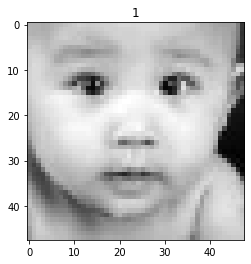

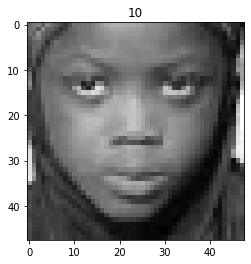

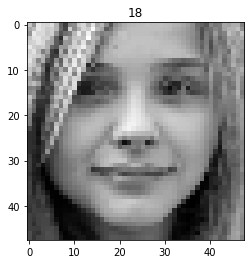

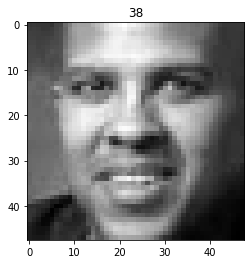

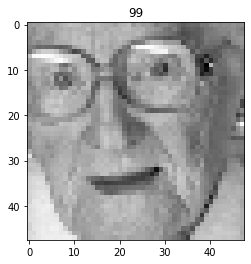

In [530]:
# view sample images
index = [0, 1250, 2500, 15000, 23704]
for idx in index:
    image = np.fromstring(dataframe['pixels'][idx], sep = ' ', dtype = np.uint8).reshape((48,48))
    plt.title(dataframe['age'][idx])
    plt.imshow(image, cmap ="gray")
    plt.show()

In [27]:
# get ratio of each age 

def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(dataframe['age'])

tot = sum(counted)

ratios = []
for i in counted:
    ratios.append([i, (counted[i]/tot)*100])

# ratios

##### Most of the pictures are labelled for age 1 and age 26. Lets look at a histogram. 

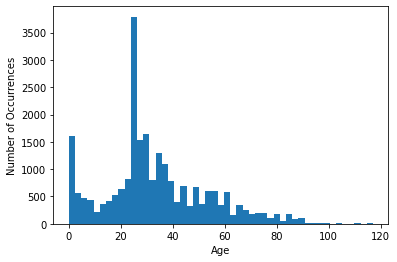

In [30]:
bin = np.linspace(0,117)
plt.hist(dataframe['age'], bins = bin)
plt.ylabel("Number of Occurrences")
plt.xlabel("Age")
plt.show() 

Not much data on over the age of 80.  

In [296]:
# Instead of ages on the year lets group by age range
# Ranges: 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, >80

grouped_DS = dataframe.drop(['age'], axis = 1)

tensRange = np.zeros(dataframe.shape[0])
for i in range(dataframe.shape[0]):
    if 0 <= dataframe['age'][i] <= 9:
        tensRange[i] = 0
    elif 10 <= dataframe['age'][i] <= 19:
        tensRange[i] = 1
    elif 20 <= dataframe['age'][i] <= 29:
        tensRange[i] = 2
    elif 30 <= dataframe['age'][i] <= 39:
        tensRange[i] = 3
    elif 40 <= dataframe['age'][i] <= 49:
        tensRange[i] = 4
    elif 50 <= dataframe['age'][i] <= 59:
        tensRange[i] = 5
    elif 60 <= dataframe['age'][i] <= 69:
        tensRange[i] = 6
    elif 70 <= dataframe['age'][i] <= 79:
        tensRange[i] = 7
    elif 80 <= dataframe['age'][i]:
        tensRange[i] = 8

        
grouped_DS['age'] = tensRange

In [297]:
grouped_DS

,ethnicity,gender,img_name,pixels,age
0,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,0.0
1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,0.0
2,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,0.0
3,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,0.0
4,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,0.0
...,...,...,...,...,...
23700,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...,8.0
23701,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...,8.0
23702,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...,8.0
23703,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...,8.0


#### New Distribution:
True Age  | Class
------------- | -------------
0-9  | 0
10-19 | 1
20-29  | 2
30-39 | 3
40-49  | 4
50-59 | 5
60-69  | 6
70-79 | 7
80+  | 8

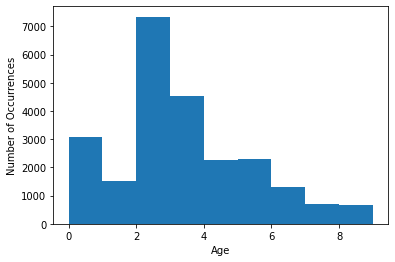

In [546]:
# see new distribution
plt.hist(grouped_DS['age'], bins = [0,1,2,3,4,5,6,7,8,9])
plt.ylabel("Number of Occurrences")
plt.xlabel("Age")
plt.show() 

In [192]:
# Generate images of shape (48,48,3) from the csv file 
# Source: https://www.kaggle.com/code/sanjay7013/age-gender-ethnicity-recognition
# Modified from above source
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, batch_size = 32, input_size=(48, 48, 3), shuffle=True):
        
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.var = 1
        self.images = []
        self.age_labels = []        
        
        # loop through df and convert string of pixels to color image arrays (48,48,3)
        for index, row in tqdm(df.iterrows()):
            image = np.fromstring(row['pixels'], sep = ' ', dtype = np.uint8).reshape((48,48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            self.images.append(image)
            
            # append labels
            self.age_labels.append(row['age'])
            
            
        self.images = np.array(self.images)
        self.age_labels = np.array(self.age_labels).astype(np.float32)
        
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        
        self.n = len(self.df)
        
    
    def __getitem__(self, index):
        images = []
        
        for i in range(self.batch_size):
            image = self.images[index * self.batch_size + i]
                
            images.append(image)
            
        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        return np.array(images), (self.age_labels[s])
    
    def __len__(self):
            
        return self.n // self.batch_size
    
    def on_epoch_end(self):
        
        #Random permutation
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]

### Train/Test/Dev split (60/20/20) (NOT GROUPED) 

In [194]:
EPOCHS = 70
BATCH_SIZE = 32

#Divide into 60/20/20 train/test/dev
msk = np.random.rand(len(dataframe)) < 0.6
train = dataframe[msk]

val = dataframe[~msk]

mskVal = np.random.rand(len(val)) < 0.5
test = val[mskVal]
dev = val[~mskVal]

train_ds = CustomDataGen(train)
test_ds = CustomDataGen(test)
dev_ds = CustomDataGen(dev)

test_ds.on_epoch_end()
x, y = test_ds[149]
print(x[0].max())
print(y[0])


14143it [00:03, 3723.12it/s]
4802it [00:00, 4891.43it/s]
4760it [00:00, 4846.06it/s]


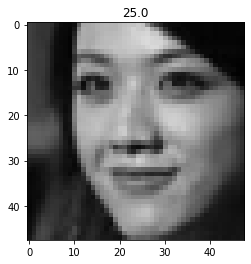

In [283]:
# Make X & Y arrays rather 
trainX = train_ds[0][0]
trainY = train_ds[0][1]
for i in range(1,441):
    trainX = np.append(trainX, train_ds[i][0])
    trainY = np.append(trainY, train_ds[i][1])

trainX = trainX.reshape(trainY.shape[0],48,48,3)

# see image
plt.imshow(trainX[37])
plt.title(trainY[37])

testX = test_ds[0][0]
testY = test_ds[0][1]
for i in range(1,150):
    testX = np.append(testX, test_ds[i][0])
    testY = np.append(testY, test_ds[i][1])
    
testX = testX.reshape(testY.shape[0],48,48,3)

devX = dev_ds[0][0]
devY = dev_ds[0][1]
for i in range(1,148):
    devX = np.append(devX, dev_ds[i][0])
    devY = np.append(devY, dev_ds[i][1])
    
devX = devX.reshape(devY.shape[0],48,48,3)

### Train/Test/Dev split (60/20/20) (GROUPED) 

In [300]:
# Same thing as above only on the grouped data now 

# Divide into 60/20/20 train/test/dev
msk = np.random.rand(len(grouped_DS)) < 0.6
trainG = grouped_DS[msk]

val = grouped_DS[~msk]

mskVal = np.random.rand(len(val)) < 0.5
testG = val[mskVal]
devG = val[~mskVal]

trainG_ds = CustomDataGen(trainG)
testG_ds = CustomDataGen(testG)
devG_ds = CustomDataGen(devG)


14221it [00:03, 3647.55it/s]
4706it [00:00, 4717.27it/s]
4778it [00:01, 4643.76it/s]


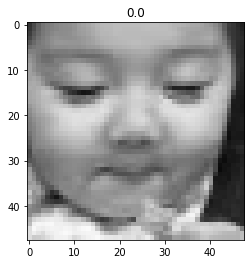

In [301]:
trainGX = trainG_ds[0][0]
trainGY = trainG_ds[0][1]
for i in range(1,444):
    trainGX = np.append(trainGX, trainG_ds[i][0])
    trainGY = np.append(trainGY, trainG_ds[i][1])

trainGX = trainGX.reshape(trainGY.shape[0],48,48,3)

# see image
plt.imshow(trainGX[37])
plt.title(trainGY[37])

testGX = testG_ds[0][0]
testGY = testG_ds[0][1]
for i in range(1,147):
    testGX = np.append(testGX, testG_ds[i][0])
    testGY = np.append(testGY, testG_ds[i][1])
    
testGX = testGX.reshape(testGY.shape[0],48,48,3)

devGX = devG_ds[0][0]
devGY = devG_ds[0][1]
for i in range(1,149):
    devGX = np.append(devGX, devG_ds[i][0])
    devGY = np.append(devGY, devG_ds[i][1])
    
devGX = devGX.reshape(devGY.shape[0],48,48,3)

In [313]:
# Normalize the Data btwn 0 & 1
if np.max(trainX) > 1.0:
    trainX = trainX/255
    testX = testX/255
    devX = devX/255

    trainGX = trainGX/255
    testGX = testGX/255
    devGX = devGX/255
else: 
    print("you already ran this")

you already ran this


## Benchmark (NOT GROUPED)
* Logistic Regression 

In [288]:
# Reshape images from (#, 48, 48, 3) to (#, 48*48*3) or (#, 6912)
benchmarkTrainX = trainX.reshape(trainY.shape[0],6912)
benchmarkTestX = testX.reshape(testY.shape[0],6912)
print(benchmarkTrainX.shape)
print(benchmarkTestX.shape)

(14112, 6912)
(4800, 6912)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe


Classification Report:

               precision    recall  f1-score   support

         1.0       0.66      0.59      0.62       236
         2.0       0.23      0.23      0.23       101
         3.0       0.12      0.12      0.12        64
         4.0       0.16      0.16      0.16        58
         5.0       0.10      0.07      0.08        40
         6.0       0.14      0.09      0.11        33
         7.0       0.10      0.04      0.06        25
         8.0       0.11      0.11      0.11        54
         9.0       0.06      0.03      0.04        37
        10.0       0.04      0.03      0.04        32
        11.0       0.00      0.00      0.00        14
        12.0       0.15      0.12      0.13        25
        13.0       0.00      0.00      0.00        20
        14.0       0.00      0.00      0.00        30
        15.0       0.09      0.12      0.11        33
        16.0       0.03      0.03      0.03        40
        17.0       0.05      0.03      0.04        35
 

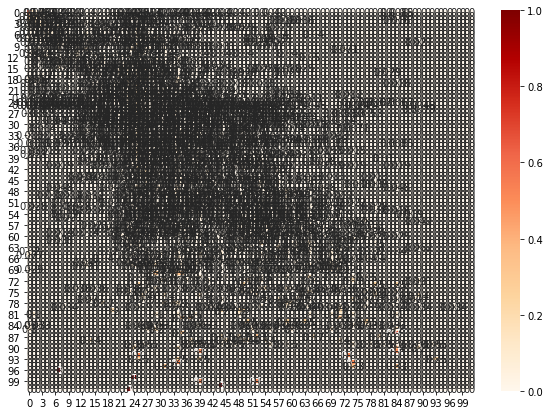

In [289]:
from sklearn.linear_model import LogisticRegression

# Train & Pred. w/ Log. Reg.  
logReg = LogisticRegression(max_iter=10000)
y_pred = logReg.fit(benchmarkTrainX, trainY).predict(benchmarkTestX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, y_pred))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testY, y_pred, normalize='true'), cmap='OrRd', annot = True)

Whoops that confusion matrix is annotated and sorta small. Let's look at a bigger and not annoted version. 

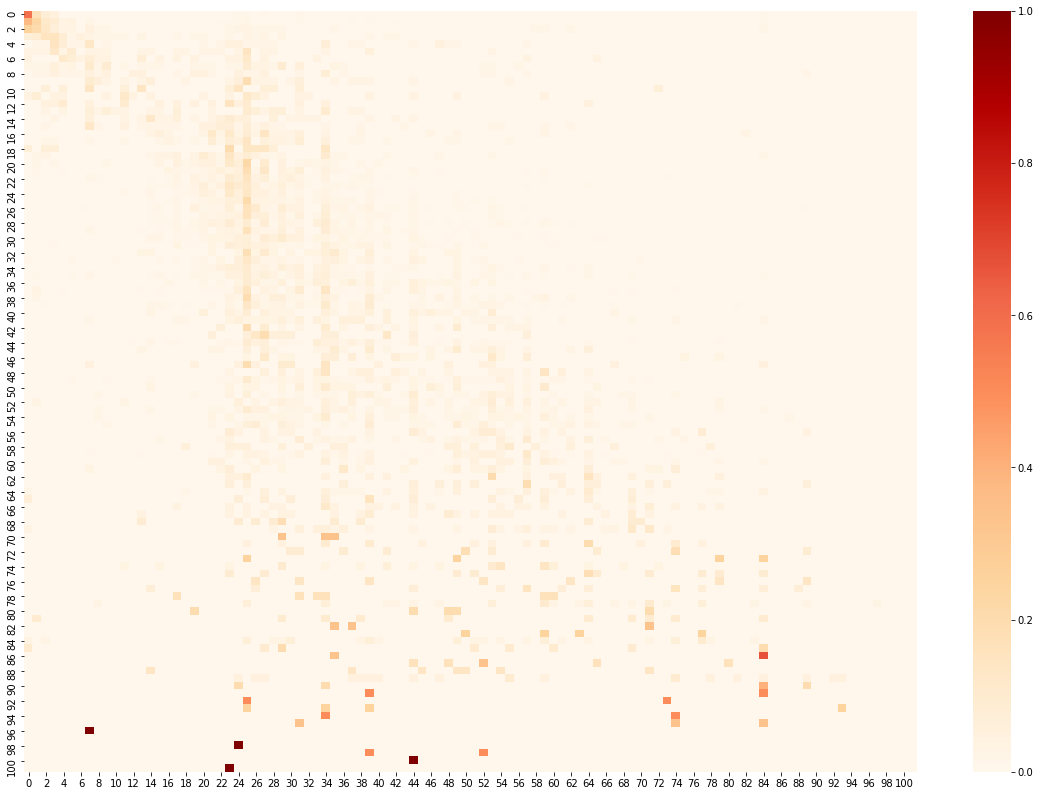

In [290]:
plt.figure(figsize = (20,14))
sn.heatmap(confusion_matrix(testY, y_pred, normalize='true'), cmap='OrRd', annot = False)

## Benchmark (GROUPED)
* Logistic Regression 

In [302]:
# Reshape images from (#, 48, 48, 3) to (#, 48*48*3) or (#, 6912)
benchmarkTrainGX = trainGX.reshape(trainGY.shape[0],6912)
benchmarkTestGX = testGX.reshape(testGY.shape[0],6912)
print(benchmarkTrainGX.shape)
print(benchmarkTestGX.shape)

(14208, 6912)
(4704, 6912)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report:

               precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       584
         1.0       0.21      0.29      0.25       294
         2.0       0.56      0.53      0.54      1483
         3.0       0.31      0.26      0.28       933
         4.0       0.17      0.18      0.18       434
         5.0       0.23      0.26      0.24       428
         6.0       0.20      0.21      0.21       285
         7.0       0.20      0.22      0.21       132
         8.0       0.34      0.26      0.29       131

    accuracy                           0.40      4704
   macro avg       0.33      0.33      0.33      4704
weighted avg       0.41      0.40      0.40      4704


Confusion Matrix:



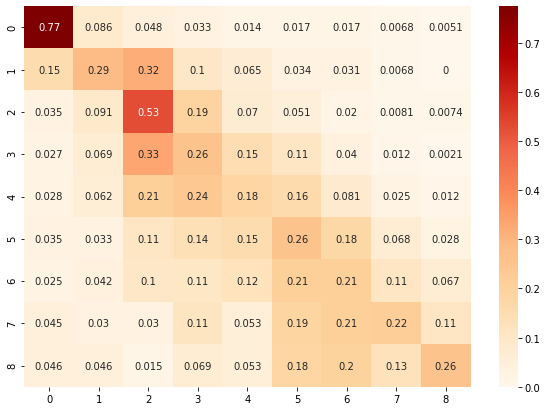

In [303]:
from sklearn.linear_model import LogisticRegression

# Train & Pred. w/ Log. Reg.  
logReg = LogisticRegression(max_iter=10000)
y_pred = logReg.fit(benchmarkTrainGX, trainGY).predict(benchmarkTestGX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, y_pred))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, y_pred, normalize='true'), cmap='OrRd', annot = True)

This performed better than I expected. Maintains somewhat of a diagnol. 

## Training / Tuning (GROUPED)
* CNN
* Transfer Learning 
* Ensemble

In [554]:
# Initial Model
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9))

model.summary()

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_467 (Conv2D)          (None, 46, 46, 16)        448       
_________________________________________________________________
conv2d_468 (Conv2D)          (None, 44, 44, 16)        2320      
_________________________________________________________________
max_pooling2d_177 (MaxPoolin (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_469 (Conv2D)          (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_470 (Conv2D)          (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_178 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_471 (Conv2D)          (None, 3, 3, 32)       

Epoch 1/12
444/444 [==============================] - 72s 158ms/step - loss: 1.6572 - accuracy: 0.3956 - val_loss: 1.4702 - val_accuracy: 0.4426
Epoch 2/12
444/444 [==============================] - 52s 118ms/step - loss: 1.4095 - accuracy: 0.4613 - val_loss: 1.3724 - val_accuracy: 0.4745
Epoch 3/12
444/444 [==============================] - 55s 124ms/step - loss: 1.3091 - accuracy: 0.4894 - val_loss: 1.2956 - val_accuracy: 0.4881
Epoch 4/12
444/444 [==============================] - 59s 132ms/step - loss: 1.2243 - accuracy: 0.5176 - val_loss: 1.2473 - val_accuracy: 0.5030
Epoch 5/12
444/444 [==============================] - 49s 109ms/step - loss: 1.1486 - accuracy: 0.5410 - val_loss: 1.2219 - val_accuracy: 0.5055
Epoch 6/12
444/444 [==============================] - 46s 105ms/step - loss: 1.0924 - accuracy: 0.5590 - val_loss: 1.1907 - val_accuracy: 0.5183
Epoch 7/12
444/444 [==============================] - 49s 111ms/step - loss: 1.0383 - accuracy: 0.5758 - val_loss: 1.2168 - val_ac

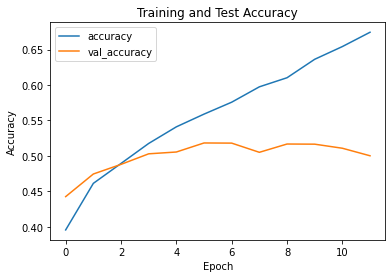

In [323]:
# Initial Model 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(trainGX, trainGY, validation_data = (testGX, testGY), epochs= 12 )

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

Best Vall Loss: 1.1907 (val_acc = 51.83%, train_acc = 55.90%) at 6 epoch. 
Val_acc plateaus while train_acc continues to increase, suggests overfitting / memorizing data. 
I shaould have saved the model, let's run somwthing similiar and increase pooling (maybe will help with oveerfitting?)

Epoch 1/15
444/444 [==============================] - 30s 65ms/step - loss: 1.7478 - accuracy: 0.3746 - val_loss: 1.4989 - val_accuracy: 0.4349
Epoch 2/15
444/444 [==============================] - 30s 67ms/step - loss: 1.4518 - accuracy: 0.4496 - val_loss: 1.3537 - val_accuracy: 0.4798
Epoch 3/15
444/444 [==============================] - 28s 64ms/step - loss: 1.3457 - accuracy: 0.4790 - val_loss: 1.3078 - val_accuracy: 0.4985
Epoch 4/15
444/444 [==============================] - 30s 68ms/step - loss: 1.2725 - accuracy: 0.5005 - val_loss: 1.2440 - val_accuracy: 0.5074
Epoch 5/15
444/444 [==============================] - 29s 64ms/step - loss: 1.2173 - accuracy: 0.5167 - val_loss: 1.2323 - val_accuracy: 0.5108
Epoch 6/15
444/444 [==============================] - 28s 63ms/step - loss: 1.1749 - accuracy: 0.5315 - val_loss: 1.2179 - val_accuracy: 0.5140
Epoch 7/15
444/444 [==============================] - 29s 66ms/step - loss: 1.1310 - accuracy: 0.5415 - val_loss: 1.1878 - val_accuracy:

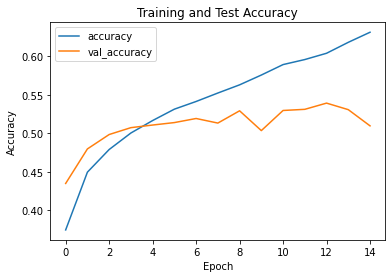

In [496]:
# Model 1
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9))


# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_01.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False)  

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(trainGX, trainGY, validation_data = (testGX, testGY), epochs= 15, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

Best Val Loss = 1.1681 at 52.93% acc at 9 epoch. If ran for more epoch (based on the upwards trend of train_acc), then the model would evetually have a hightraining accuracy, but likely a val_acc around ~50% (bc val_acc plateaus). Inidcating overfitting.


Classification Report:

               precision    recall  f1-score   support

         0.0       0.86      0.91      0.88       584
         1.0       0.47      0.38      0.42       294
         2.0       0.67      0.68      0.67      1483
         3.0       0.39      0.29      0.33       933
         4.0       0.25      0.16      0.20       434
         5.0       0.29      0.49      0.36       428
         6.0       0.27      0.32      0.29       285
         7.0       0.22      0.12      0.16       132
         8.0       0.40      0.71      0.51       131

    accuracy                           0.51      4704
   macro avg       0.42      0.45      0.43      4704
weighted avg       0.51      0.51      0.50      4704


Confusion Matrix:



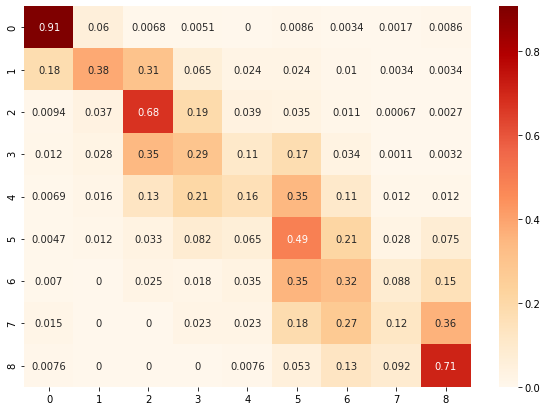

In [498]:
# load best model
load_model('model_01.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

* Good with: 0-9, 20-29, 80+
* Decent with: 10-19, 50-59
* Bad with: 40-49, 70-79
* Confuses classes with neighbors (for most part), so makes sense.

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_404 (Conv2D)          (None, 46, 46, 16)        448       
_________________________________________________________________
conv2d_405 (Conv2D)          (None, 44, 44, 16)        2320      
_________________________________________________________________
max_pooling2d_152 (MaxPoolin (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_406 (Conv2D)          (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_407 (Conv2D)          (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_408 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_153 (MaxPoolin (None, 4, 4, 128)       

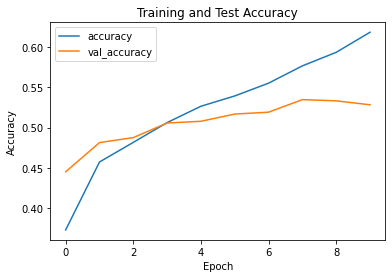

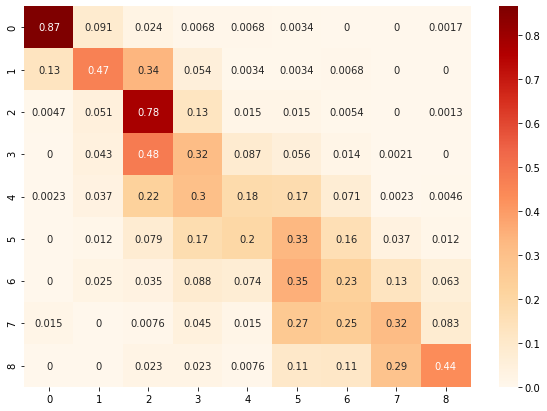

In [500]:
# Model 3
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9))


# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_03.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False)  

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

history = model.fit(trainGX, trainGY, validation_data = (testGX, testGY), epochs= 10, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

# load best model
load_model('model_03.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_472 (Conv2D)          (None, 47, 47, 16)        208       
_________________________________________________________________
conv2d_473 (Conv2D)          (None, 46, 46, 16)        1040      
_________________________________________________________________
batch_normalization_17 (Batc (None, 46, 46, 16)        64        
_________________________________________________________________
max_pooling2d_179 (MaxPoolin (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_474 (Conv2D)          (None, 13, 13, 32)        4640      
_________________________________________________________________
conv2d_475 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_476 (Conv2D)          (None, 9, 9, 128)      

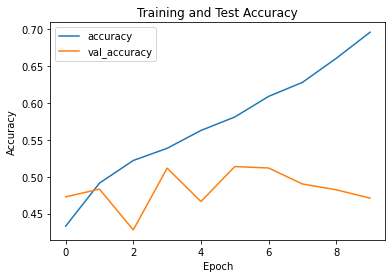

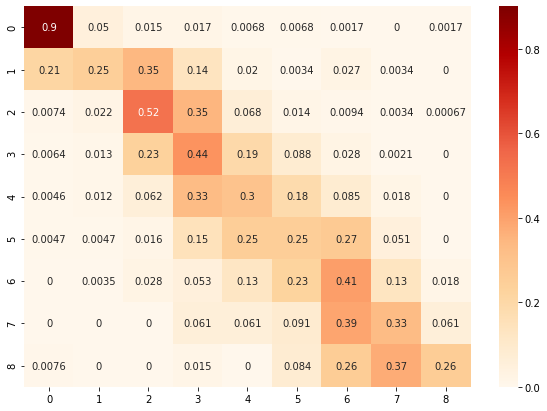

In [555]:
# Model 3
model = models.Sequential()
model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(16, (2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9))


# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_03b.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False)  

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

history = model.fit(trainGX, trainGY, validation_data = (testGX, testGY), epochs= 10, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

# load best model
load_model('model_03b.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)


Classification Report:

               precision    recall  f1-score   support

         0.0       0.95      0.80      0.87       584
         1.0       0.54      0.19      0.29       294
         2.0       0.61      0.69      0.65      1483
         3.0       0.37      0.52      0.43       933
         4.0       0.32      0.12      0.17       434
         5.0       0.34      0.43      0.38       428
         6.0       0.34      0.14      0.19       285
         7.0       0.16      0.22      0.19       132
         8.0       0.48      0.60      0.53       131

    accuracy                           0.51      4704
   macro avg       0.46      0.41      0.41      4704
weighted avg       0.52      0.51      0.50      4704


Confusion Matrix:



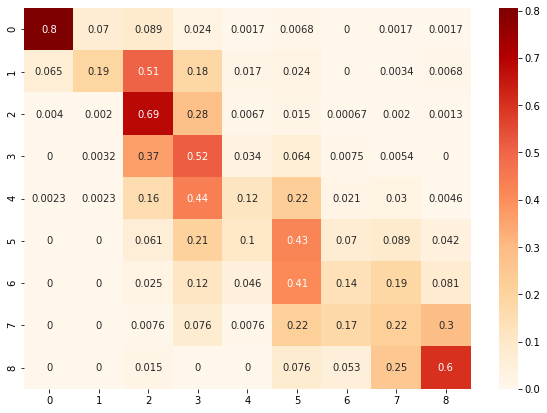

In [557]:
# load best model
model = load_model('model_03b.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_399 (Conv2D)          (None, 46, 46, 128)       3584      
_________________________________________________________________
conv2d_400 (Conv2D)          (None, 44, 44, 256)       295168    
_________________________________________________________________
max_pooling2d_149 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_401 (Conv2D)          (None, 12, 12, 128)       295040    
_________________________________________________________________
max_pooling2d_150 (MaxPoolin (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_402 (Conv2D)          (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_403 (Conv2D)          (None, 2, 2, 128)       

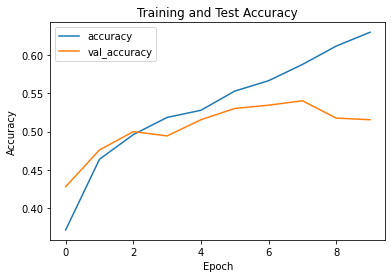

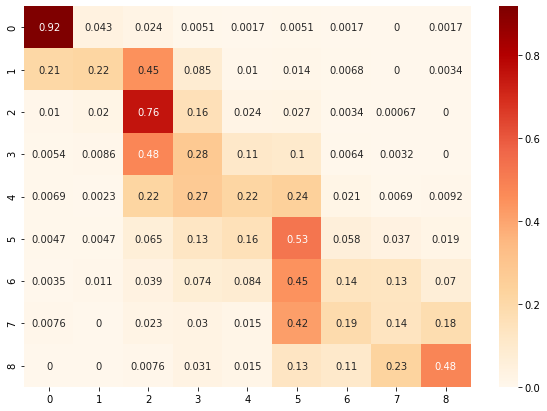

In [499]:
# Model 2
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9))


# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_02.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False)  

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

history = model.fit(trainGX, trainGY, validation_data = (testGX, testGY), epochs= 10, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

# load best model
load_model('model_02.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_420 (Conv2D)          (None, 46, 46, 64)        1792      
_________________________________________________________________
conv2d_421 (Conv2D)          (None, 44, 44, 128)       73856     
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_422 (Conv2D)          (None, 12, 12, 128)       147584    
_________________________________________________________________
conv2d_423 (Conv2D)          (None, 10, 10, 256)       295168    
_________________________________________________________________
conv2d_424 (Conv2D)          (None, 8, 8, 512)         1180160   
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 4, 4, 512)       

AttributeError: 'Sequential' object has no attribute 'load_model'

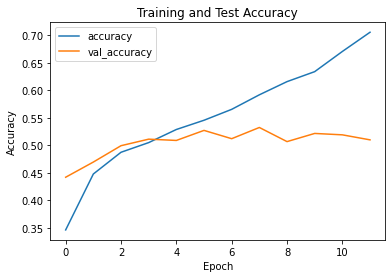

In [504]:
# Model 4
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9))


# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_04.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False)  

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

history = model.fit(trainGX, trainGY, validation_data = (testGX, testGY), epochs= 12, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

# load best model
load_model('model_04.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)


Classification Report:

               precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       584
         1.0       0.38      0.41      0.39       294
         2.0       0.63      0.68      0.65      1483
         3.0       0.39      0.35      0.37       933
         4.0       0.26      0.20      0.23       434
         5.0       0.33      0.42      0.37       428
         6.0       0.30      0.27      0.29       285
         7.0       0.27      0.20      0.23       132
         8.0       0.56      0.48      0.52       131

    accuracy                           0.51      4704
   macro avg       0.44      0.43      0.43      4704
weighted avg       0.50      0.51      0.50      4704


Confusion Matrix:



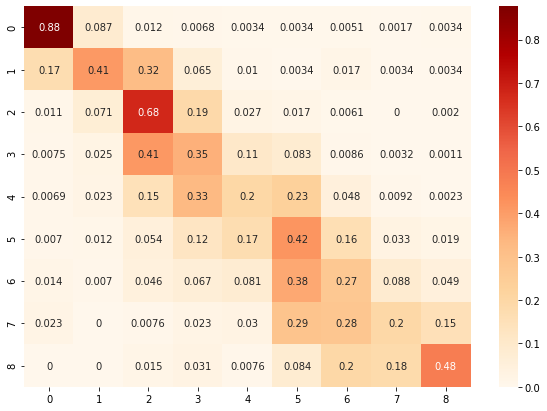

In [505]:
# ope error loading model, forgot to fix something (its fixed above now, but let's run it here)
# load best model
load_model('model_04.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_426 (Conv2D)          (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_427 (Conv2D)          (None, 40, 40, 128)       204928    
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_428 (Conv2D)          (None, 18, 18, 128)       147584    
_________________________________________________________________
conv2d_429 (Conv2D)          (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_430 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 7, 7, 128)       

AttributeError: 'Sequential' object has no attribute 'load_model'

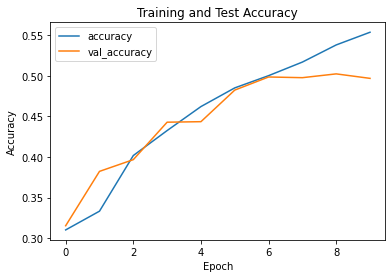

In [506]:
# Model 5
model = models.Sequential()
model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9))


# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_05.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False)  

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

history = model.fit(trainGX, trainGY, validation_data = (testGX, testGY), epochs= 10, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

# load best model
load_model('model_05.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)


Classification Report:

               precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       584
         1.0       0.38      0.27      0.32       294
         2.0       0.55      0.85      0.67      1483
         3.0       0.34      0.23      0.28       933
         4.0       0.25      0.07      0.11       434
         5.0       0.28      0.32      0.30       428
         6.0       0.26      0.14      0.19       285
         7.0       0.18      0.23      0.20       132
         8.0       0.51      0.24      0.33       131

    accuracy                           0.50      4704
   macro avg       0.40      0.36      0.36      4704
weighted avg       0.46      0.50      0.46      4704


Confusion Matrix:



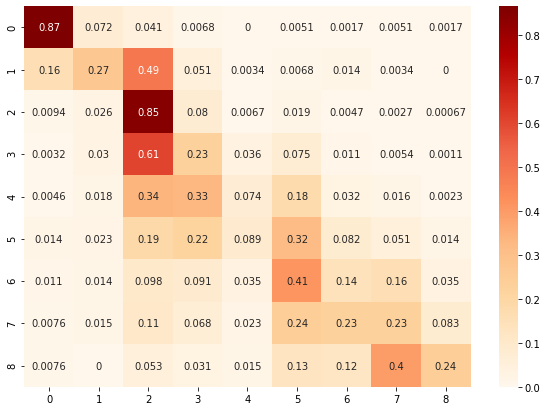

In [507]:
# ope error loading model, forgot to fix something (its fixed above now, but let's run it here)
# load best model
load_model('model_05.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_415 (Conv2D)          (None, 46, 46, 16)        448       
_________________________________________________________________
conv2d_416 (Conv2D)          (None, 44, 44, 16)        2320      
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_417 (Conv2D)          (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_418 (Conv2D)          (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_419 (Conv2D)          (None, 3, 3, 32)        

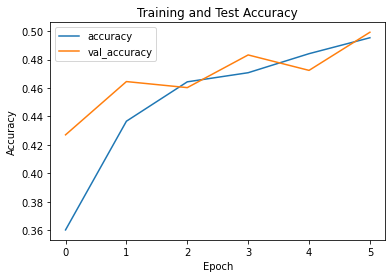

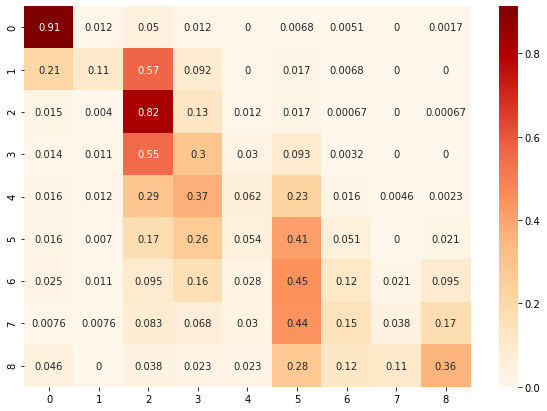

In [503]:
# Model 6
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9))


# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_06.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False)  

model.compile(optimizer='adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

history = model.fit(trainGX, trainGY, validation_data = (testGX, testGY), epochs= 6, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

# load best model
load_model('model_06.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_457 (Conv2D)          (None, 46, 46, 16)        448       
_________________________________________________________________
conv2d_458 (Conv2D)          (None, 44, 44, 16)        2320      
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_459 (Conv2D)          (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_460 (Conv2D)          (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_461 (Conv2D)          (None, 3, 3, 32)        

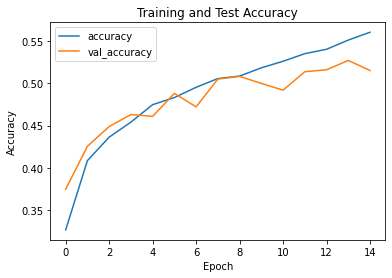

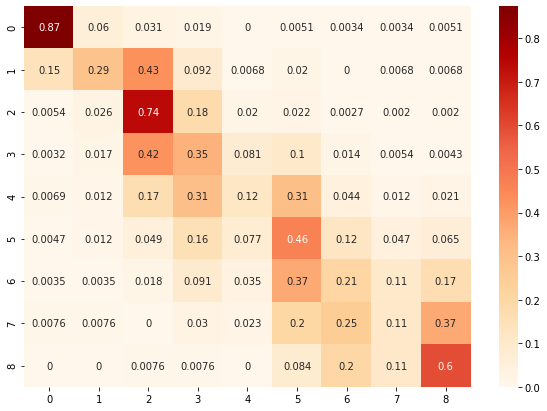

In [552]:
# Model 6
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9))


# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_06b.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False)  

model.compile(optimizer='adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

history = model.fit(trainGX, trainGY, validation_data = (testGX, testGY), epochs= 15, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

# load best model
load_model('model_06b.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

Let's also try batch normalization for overfitting

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_410 (Conv2D)          (None, 46, 46, 16)        448       
_________________________________________________________________
conv2d_411 (Conv2D)          (None, 44, 44, 16)        2320      
_________________________________________________________________
batch_normalization_14 (Batc (None, 44, 44, 16)        64        
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_412 (Conv2D)          (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_413 (Conv2D)          (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 5, 5, 64)        

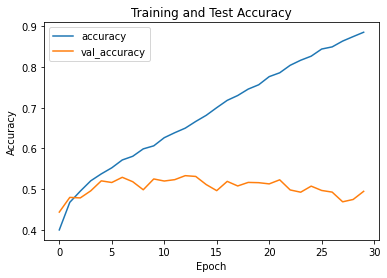

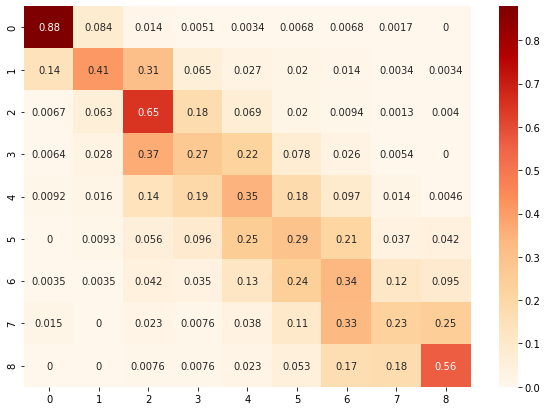

In [502]:
# Model 8
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9))


# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_08.h5', monitor='val_loss', save_best_only=True, mode='min', save_weights_only = False)  

model.compile(optimizer='adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

history = model.fit(trainGX, trainGY, validation_data = (testGX, testGY), epochs= 30, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

# load best model
load_model('model_08.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

Best model occurred at 10 epoch. That is the one displayed. I increased epoch to see if training acc would continue to grow while val_acc would not grow and that happened. The diagnal is there, it just confuses ages in a 30 yr span (i.e classifies 50-59 correctly 29% and as 40-49 25% of the time and 60-69 21% of the time. I'm wondering if there are not enough fundemental differnces in the images to disguinsh the ages (especially bc the images are 48 by 48).

In [549]:
# Saw that it was struggling with certian classes (4,7,3,6)
# thought couod weight those classes heavier to increase their classifications
# through iterations, I saw that the model didn't want to classify many images as class 7
# however, this did not work. I went through many weight variations and none worked
# despite weighting class 7 heavily, the model still refused to class many as 7
# Bc of bad performances, no example is included
# But heres the code: 
custom_weights = tf.constant([
    [0.8, 1., 1., 1.1, 1.3, 1., 1.1, 1.5, 1.],
    [0.8, 1., 1., 1.1, 1.3, 1., 1.1, 1.5, 1.],
    [0.8, 1., 1., 1.1, 1.3, 1., 1.1, 1.5, 1.],
    [0.8, 1., 1., 1.1, 1.3, 1., 1.1, 1.5, 1.],
    [0.8, 1., 1., 1.1, 1.3, 1., 1.1, 1.5, 1.],
    [0.8, 1., 1., 1.1, 1.3, 1., 1.1, 1.5, 1.],
    [0.8, 1., 1., 1.1, 1.3, 1., 1.1, 1.5, 1.],
    [0.8, 1., 1., 1.1, 1.3, 1., 1.1, 1.5, 1.],
    [0.8, 1., 1., 1.1, 1.3, 1., 1.1, 1.5, 1.]])



def custom_loss(y_true, y_pred):
    # get the prediction from the final softmax layer:
    pred_idx = tf.argmax(y_pred, axis=1, output_type=tf.int32)

    # stack these so we have a tensor of [[predicted_i, actual_i], ...,] for each i in batch
    indices = tf.stack([tf.reshape(pred_idx, (-1,)), 
                        tf.reshape(tf.cast( y_true, tf.int32), (-1,))], axis=1)

  # use tf.gather_nd() to convert indices to the appropriate weight from our matrix [w_i, ...] for each i in batch
    batch_weights = tf.gather_nd(custom_weights, indices)
    
    return batch_weights * tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)


I don't think I'll be able to do much better on my own. 

### Transfer Learning


In [410]:
# Normalize data btwn -1 and 1
if np.min(trainGtX) != -1:
    trainGtX = (trainGX*2)-1
    testGtX = (testGX*2)-1
    devGtX = (devGX*2)-1
else: 
    print("you already ran this")

you already ran this


In [558]:
def build_model(input_shape = (48,48,3)):
    
    i = tf.keras.layers.Input(input_shape, dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    
    backbone = tf.keras.applications.MobileNet(
                include_top=False, weights='imagenet',
                input_tensor=x
            )
    output_layer = backbone.get_layer("conv_pw_13_relu").output    
    
    
    def build_age_branch(input_tensor): 
        x = tf.keras.layers.Dense(1024, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(9, activation = None, name = 'age_output')(x)
    
        return x
    
    x = tf.keras.layers.Flatten()(output_layer)       
    output_age = build_age_branch(x)

    model = tf.keras.Model(i, output_age)
    
    return model
    

In [559]:
model = build_model()
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.cast_18 (TFOpLambda)      (None, 48, 48, 3)         0         
_________________________________________________________________
tf.math.truediv_9 (TFOpLambd (None, 48, 48, 3)         0         
_________________________________________________________________
tf.math.subtract_9 (TFOpLamb (None, 48, 48, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0  

In [560]:
## Compile
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss = ['mse'], loss_weights = [0.001], 
              metrics = {'age_output': 'mean_absolute_error'})

## Callbacks 
# Reduce learning rate when a metric has stopped improving
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  

# Early stopping (stops training when validation doesn't improve for {patience} epochs)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5) 

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('weights_v1.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False)  

## Fit
history = model.fit(trainGX, trainGY,
            epochs=EPOCHS,
            batch_size = BATCH_SIZE,
            validation_data = (testGX, testGY),
            callbacks = [es, save_best, plateau])


Epoch 1/70
444/444 [==============================] - 123s 270ms/step - loss: 0.0116 - mean_absolute_error: 2.7512 - val_loss: 0.0170 - val_mean_absolute_error: 3.4228
Epoch 2/70
444/444 [==============================] - 114s 256ms/step - loss: 0.0078 - mean_absolute_error: 2.1547 - val_loss: 0.0250 - val_mean_absolute_error: 4.1653
Epoch 3/70
444/444 [==============================] - 116s 261ms/step - loss: 0.0051 - mean_absolute_error: 1.6428 - val_loss: 0.0104 - val_mean_absolute_error: 2.5636
Epoch 4/70
444/444 [==============================] - 109s 245ms/step - loss: 0.0044 - mean_absolute_error: 1.6001 - val_loss: 0.0175 - val_mean_absolute_error: 3.4882
Epoch 5/70
444/444 [==============================] - 102s 230ms/step - loss: 0.0044 - mean_absolute_error: 1.6093 - val_loss: 0.0072 - val_mean_absolute_error: 2.1146
Epoch 6/70
444/444 [==============================] - 102s 229ms/step - loss: 0.0043 - mean_absolute_error: 1.6040 - val_loss: 0.0077 - val_mean_absolute_error:


Classification Report:

               precision    recall  f1-score   support

         0.0       0.23      0.01      0.02       584
         1.0       0.00      0.00      0.00       294
         2.0       0.07      0.00      0.00      1483
         3.0       0.19      0.01      0.02       933
         4.0       0.05      0.00      0.01       434
         5.0       0.07      0.00      0.01       428
         6.0       0.06      0.95      0.11       285
         7.0       0.06      0.02      0.02       132
         8.0       0.00      0.00      0.00       131

    accuracy                           0.06      4704
   macro avg       0.08      0.11      0.02      4704
weighted avg       0.10      0.06      0.02      4704


Confusion Matrix:



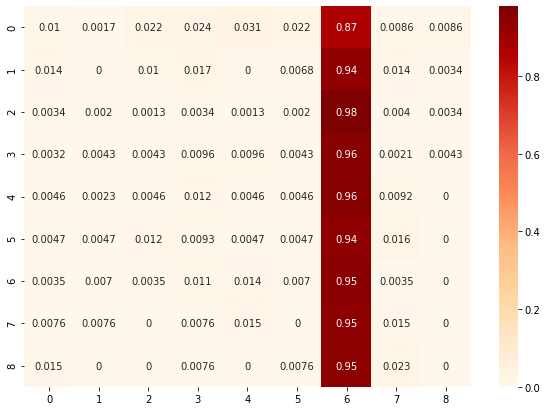

In [561]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model
 
model = load_model('weights_v1.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

I don't know why it would classify almost everything as class 6 (it does'nt even rep most of the data (not the laregst class).

No more MSE loss

### MobileNetV2

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/12
444/444 [==============================] - 27s 57ms/step - loss: 1.7180 - accuracy: 0.3814 - val_loss: 1.5831 - val_accuracy: 0.4094
Epoch 2/12
444/444 [==============================] - 25s 56ms/step - loss: 1.5037 - accuracy: 0.4385 - val_loss: 1.5648 - val_accuracy: 0.3980
Epoch 3/12
444/444 [==============================] - 24s 53ms/step - loss: 1.43

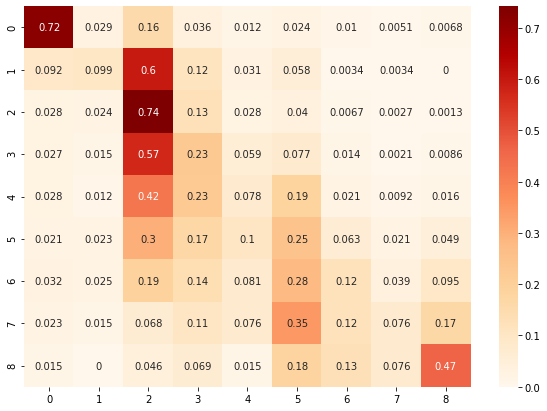

In [404]:
IMG_SHAPE = (48, 48, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# freezing the trainable hyperparemetes of the existing model. pre-trained model MobileNet V2
base_model.trainable = False 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(9)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.summary()

# base_learning_rate = 0.0001
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])


## Callbacks 
# Reduce learning rate when a metric has stopped improving
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  

# Early Stopping (stops training when validation doesn't improve for {patience} epochs)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5) 

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('weights_MobileNetV2.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False) 


history = model.fit(trainGX, trainGY, 
                    validation_data=(testGX, testGY), 
                    callbacks = [es, save_best, plateau],
                    epochs=12)

# Load best model 
model = load_model('weights_MobileNetV2.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

Epoch 1/12
444/444 [==============================] - 25s 52ms/step - loss: 1.6300 - accuracy: 0.3941 - val_loss: 1.5330 - val_accuracy: 0.4296
Epoch 2/12
444/444 [==============================] - 24s 53ms/step - loss: 1.4276 - accuracy: 0.4547 - val_loss: 1.5175 - val_accuracy: 0.4371
Epoch 3/12
444/444 [==============================] - 23s 53ms/step - loss: 1.3589 - accuracy: 0.4800 - val_loss: 1.5197 - val_accuracy: 0.4311
Epoch 4/12
444/444 [==============================] - 23s 51ms/step - loss: 1.3089 - accuracy: 0.4958 - val_loss: 1.4829 - val_accuracy: 0.4420
Epoch 5/12
444/444 [==============================] - 22s 50ms/step - loss: 1.2758 - accuracy: 0.5146 - val_loss: 1.5100 - val_accuracy: 0.4364
Epoch 6/12
444/444 [==============================] - 22s 50ms/step - loss: 1.2484 - accuracy: 0.5217 - val_loss: 1.5055 - val_accuracy: 0.4290

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/12
444/444 [==============================] - 2

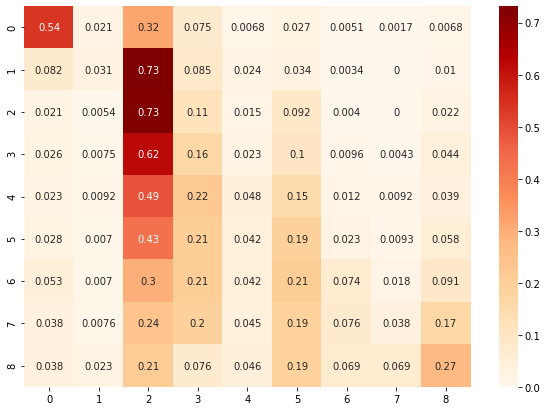

In [452]:

# RUN ME


IMG_SHAPE = (48, 48, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# freezing the trainable hyperparemetes of the existing model. pre-trained model MobileNet V2
base_model.trainable = False 

rescale_layer = tf.keras.layers.Rescaling(scale = 2, offset = -1)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(9)

model = tf.keras.Sequential([
    rescale_layer,
    base_model,
    global_average_layer,
    prediction_layer
])


# base_learning_rate = 0.0001
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Callbacks 
# Reduce learning rate when a metric has stopped improving
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  

# Early Stopping (stops training when validation doesn't improve for {patience} epochs)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5) 

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('weights_MobileNetV2_01.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False) 


history = model.fit(trainGX, trainGY, 
                    validation_data=(testGX, testGY), 
                    callbacks = [es, save_best, plateau],
                    epochs=12)

model.summary()

# Load best model 
model = load_model('weights_MobileNetV2_01.h5')

preds = model.predict(testGtX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

### VGG16

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 9)                 4617      
Total params: 14,719,305
Trainable params: 4,617
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/12
444/444 [==============================] - 132s 295ms/step - loss: 1.6912 - accuracy: 0.3782 - val_loss: 1.5709 - val_accuracy: 0.4167
Epoch 2/12
444/444 [==============================] - 128s 288ms/step - loss: 1.5486 - accuracy: 0.4186 - val_loss: 1.5173 - val_accuracy: 0.4254
Epoch 3/12
444/444 [==============================] - 126s 283ms/step - los

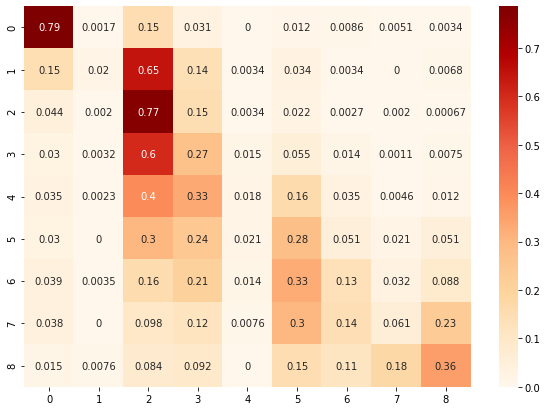

In [412]:
IMG_SHAPE = (48, 48, 3)

# Create the base model from the pre-trained model 
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# freezing the trainable hyperparemetes of the existing model. 
base_model.trainable = False 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(9)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.summary()

# base_learning_rate = 0.0001
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])


## Callbacks 
# Reduce learning rate when a metric has stopped improving
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  

# Early Stopping (stops training when validation doesn't improve for {patience} epochs)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5) 

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('weights_VGG16.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False) 


history = model.fit(trainGtX, trainGY, 
                    validation_data=(testGtX, testGY), 
                    callbacks = [es, save_best, plateau],
                    epochs=12)

# Load best model 
model = load_model('weights_VGG16.h5')


preds = model.predict(testGtX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

Epoch 1/12
444/444 [==============================] - 129s 290ms/step - loss: 1.7282 - accuracy: 0.3765 - val_loss: 1.6812 - val_accuracy: 0.3912
Epoch 2/12
444/444 [==============================] - 125s 282ms/step - loss: 1.5590 - accuracy: 0.4222 - val_loss: 1.6434 - val_accuracy: 0.4090
Epoch 3/12
444/444 [==============================] - 145s 327ms/step - loss: 1.5135 - accuracy: 0.4355 - val_loss: 1.6239 - val_accuracy: 0.4152
Epoch 4/12
444/444 [==============================] - 158s 356ms/step - loss: 1.4844 - accuracy: 0.4428 - val_loss: 1.6294 - val_accuracy: 0.4186
Epoch 5/12
444/444 [==============================] - 157s 353ms/step - loss: 1.4665 - accuracy: 0.4464 - val_loss: 1.6457 - val_accuracy: 0.4177

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/12
444/444 [==============================] - 150s 338ms/step - loss: 1.4446 - accuracy: 0.4564 - val_loss: 1.6198 - val_accuracy: 0.4211
Epoch 7/12
444/444 [=======================

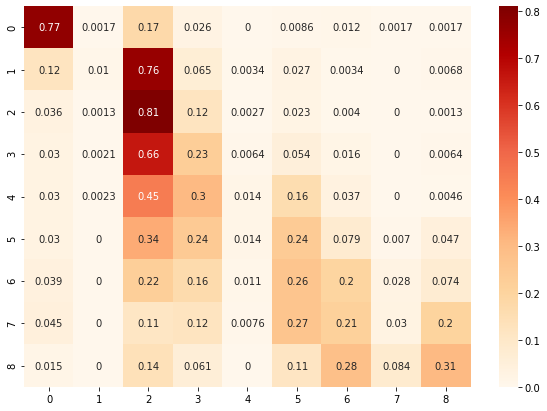

In [450]:
IMG_SHAPE = (48, 48, 3)

# Create the base model from the pre-trained model 
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# freezing the trainable hyperparemetes of the existing model. pre-trained model MobileNet V2
base_model.trainable = False 

rescale_layer = tf.keras.layers.Rescaling(scale = 2, offset = -1)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(9)

model = tf.keras.Sequential([
    rescale_layer,
    base_model,
    global_average_layer,
    prediction_layer
])

# base_learning_rate = 0.0001
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])


## Callbacks 
# Reduce learning rate when a metric has stopped improving
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  

# Early Stopping (stops training when validation doesn't improve for {patience} epochs)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5) 

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('weights_VGG16_01.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False) 


history = model.fit(trainGX, trainGY, 
                    validation_data=(testGtX, testGY), 
                    callbacks = [es, save_best, plateau],
                    epochs=12)

model.summary()

# Load best model 
model = load_model('weights_VGG16_01.h5')


preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

### EfficientNetB0

Epoch 1/12
444/444 [==============================] - 49s 99ms/step - loss: 1.6407 - accuracy: 0.3897 - val_loss: 1.5302 - val_accuracy: 0.4207
Epoch 2/12
444/444 [==============================] - 41s 92ms/step - loss: 1.5132 - accuracy: 0.4279 - val_loss: 1.4745 - val_accuracy: 0.4326
Epoch 3/12
444/444 [==============================] - 41s 92ms/step - loss: 1.4811 - accuracy: 0.4376 - val_loss: 1.4680 - val_accuracy: 0.4298
Epoch 4/12
444/444 [==============================] - 42s 94ms/step - loss: 1.4560 - accuracy: 0.4436 - val_loss: 1.4424 - val_accuracy: 0.4522
Epoch 5/12
444/444 [==============================] - 42s 95ms/step - loss: 1.4480 - accuracy: 0.4521 - val_loss: 1.4443 - val_accuracy: 0.4392
Epoch 6/12
444/444 [==============================] - 43s 98ms/step - loss: 1.4294 - accuracy: 0.4543 - val_loss: 1.4367 - val_accuracy: 0.4471
Epoch 7/12
444/444 [==============================] - 43s 96ms/step - loss: 1.4152 - accuracy: 0.4630 - val_loss: 1.4510 - val_accuracy:

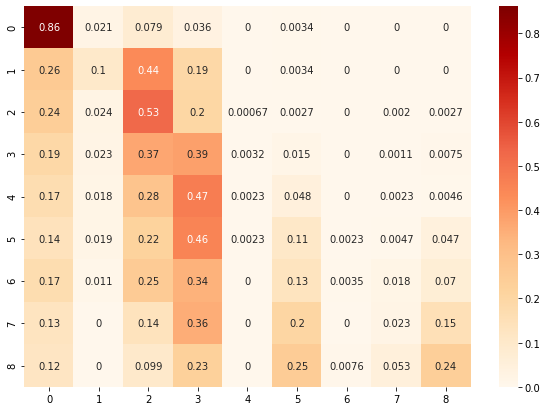

In [440]:
## EfficientNetB0 expects inputs between 0 & 255

IMG_SHAPE = (48, 48, 3)

# Create the base model from the pre-trained model 
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# freezing the trainable hyperparemetes of the existing model. pre-trained model MobileNet V2
base_model.trainable = False 

rescale_layer = tf.keras.layers.Rescaling(scale = 255)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(9)

model = tf.keras.Sequential([
    rescale_layer,
    base_model,
    global_average_layer,
    prediction_layer
])


# base_learning_rate = 0.0001
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])


## Callbacks 
# Reduce learning rate when a metric has stopped improving
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  

# Early Stopping (stops training when validation doesn't improve for {patience} epochs)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5) 

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('weights_EfficientNetB0.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False) 


history = model.fit(trainGX, trainGY, 
                    validation_data=(testGX, testGY), 
                    callbacks = [es, save_best, plateau],
                    epochs=12)

model.summary()

# Load best model 
model = load_model('weights_EfficientNetB0.h5')

preds = model.predict(testGtX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

### Ensemble Model 

In [509]:
# Load the model
keras_model = tf.keras.models.load_model('model_01.h5', compile=False)
keras_model._name = 'model1'
keras_model2 = tf.keras.models.load_model('model_02.h5', compile=False)
keras_model2._name = 'model2'
keras_model3 = tf.keras.models.load_model('model_03.h5', compile=False)
keras_model3._name = 'model3'
keras_model4 = tf.keras.models.load_model('model_04.h5', compile=False)
keras_model4._name = 'model4'
keras_model5= tf.keras.models.load_model('model_05.h5', compile=False)
keras_model5._name = 'model5'
keras_model6 = tf.keras.models.load_model('model_06.h5', compile=False)
keras_model6._name = 'model6'
keras_model7 = tf.keras.models.load_model('model_08.h5', compile=False)
keras_model7._name = 'model7'

# keras_model8 = tf.keras.models.load_model('weights_MobileNetV2_01.h5', compile=False)
# keras_model8._name = 'model8'
# keras_model9 = tf.keras.models.load_model('weights_EfficientNetB0.h5', compile=False)
# keras_model9._name = 'model9'
# keras_model10 = tf.keras.models.load_model('weights_VGG16_01.h5', compile=False)
# keras_model10._name = 'model10'

models = [keras_model, keras_model2, keras_model3, keras_model4, keras_model5, keras_model6, keras_model7]
model_input = tf.keras.Input(shape=(48, 48, 3))

model_outputs = [model(model_input) for model in models]

ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)  

ensemble_model.save('ensemble_01.h5')

Epoch 1/12
444/444 [==============================] - 760s 2s/step - loss: 0.8849 - accuracy: 0.6317 - val_loss: 1.1361 - val_accuracy: 0.5385
Epoch 2/12
444/444 [==============================] - 753s 2s/step - loss: 0.7913 - accuracy: 0.6725 - val_loss: 1.2084 - val_accuracy: 0.5257
Epoch 3/12
444/444 [==============================] - 746s 2s/step - loss: 0.7164 - accuracy: 0.7047 - val_loss: 1.2253 - val_accuracy: 0.5495

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
444/444 [==============================] - 748s 2s/step - loss: 0.4625 - accuracy: 0.8238 - val_loss: 1.4675 - val_accuracy: 0.5440
Epoch 5/12
444/444 [==============================] - 743s 2s/step - loss: 0.3491 - accuracy: 0.8699 - val_loss: 1.5756 - val_accuracy: 0.5366

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/12
444/444 [==============================] - 749s 2s/step - loss: 0.2169 - accuracy: 0.9355 - val_loss: 1.7611 - v

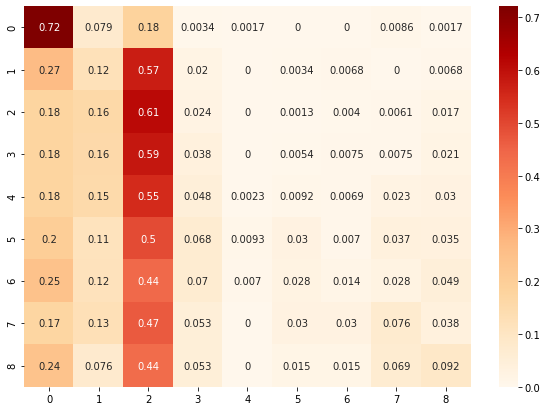

In [510]:

ensemble_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                       metrics=['accuracy'])


## Callbacks 
# Reduce learning rate when a metric has stopped improving
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  

# Early Stopping (stops training when validation doesn't improve for {patience} epochs)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5) 

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('ensemble_01.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False) 


history = ensemble_model.fit(trainGX, trainGY, 
                    validation_data=(testGX, testGY), 
                    callbacks = [es, save_best, plateau],
                    epochs=12)

ensemble_model.summary()

# Load best model 
model = load_model('ensemble_01.h5')

preds = model.predict(testGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testGY, preds, normalize='true'), cmap='OrRd', annot = True)

# Exact Age CNN

Epoch 1/30
441/441 [==============================] - 163s 369ms/step - loss: 4.3330 - accuracy: 0.0718 - val_loss: 4.0177 - val_accuracy: 0.0875
Epoch 2/30
441/441 [==============================] - 164s 371ms/step - loss: 3.9455 - accuracy: 0.1111 - val_loss: 3.8108 - val_accuracy: 0.1258
Epoch 3/30
441/441 [==============================] - 164s 372ms/step - loss: 3.7591 - accuracy: 0.1356 - val_loss: 3.7111 - val_accuracy: 0.1315
Epoch 4/30
441/441 [==============================] - 158s 359ms/step - loss: 3.6063 - accuracy: 0.1368 - val_loss: 3.5868 - val_accuracy: 0.1354
Epoch 5/30
441/441 [==============================] - 158s 358ms/step - loss: 3.4971 - accuracy: 0.1421 - val_loss: 3.5204 - val_accuracy: 0.1340
Epoch 6/30
441/441 [==============================] - 157s 355ms/step - loss: 3.4212 - accuracy: 0.1441 - val_loss: 3.4883 - val_accuracy: 0.1404
Epoch 7/30
441/441 [==============================] - 160s 363ms/step - loss: 3.3626 - accuracy: 0.1472 - val_loss: 3.4579 -

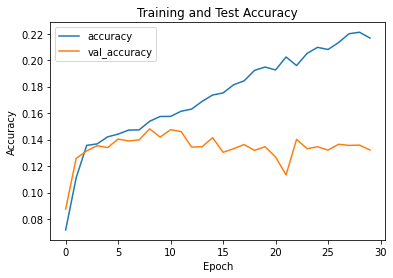

In [208]:
# Initial Model 
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(48,48,3)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(117))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data = test_ds, epochs = 30 )

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_440 (Conv2D)          (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_441 (Conv2D)          (None, 40, 40, 128)       204928    
_________________________________________________________________
max_pooling2d_166 (MaxPoolin (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_442 (Conv2D)          (None, 18, 18, 128)       147584    
_________________________________________________________________
conv2d_443 (Conv2D)          (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_444 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_167 (MaxPoolin (None, 7, 7, 128)       

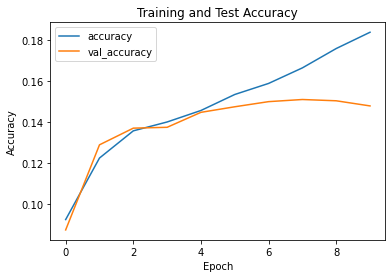

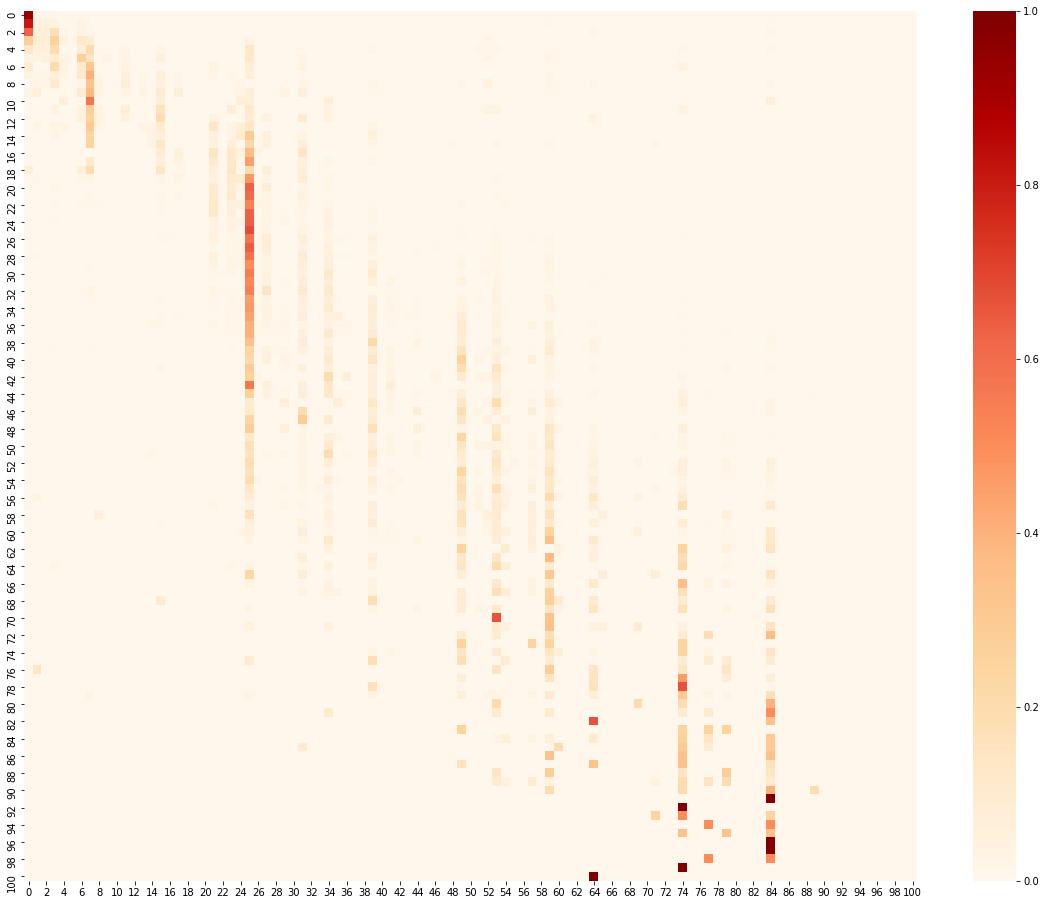

In [524]:
# Initial Model 
model = models.Sequential()
model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(117))


# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('modelW_01.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = False)  

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

history = model.fit(trainX, trainY, validation_data = (testX, testY), epochs= 10, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'best')

# load best model
load_model('modelW_01.h5')

preds = model.predict(testX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (20,16))
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='OrRd', annot = False)


## Dev Set Evaluation
* Chosen model: model 2


Classification Report:

               precision    recall  f1-score   support

         0.0       0.91      0.87      0.89       636
         1.0       0.48      0.30      0.37       297
         2.0       0.61      0.80      0.69      1449
         3.0       0.38      0.36      0.37       896
         4.0       0.33      0.15      0.20       471
         5.0       0.38      0.44      0.41       472
         6.0       0.34      0.27      0.30       270
         7.0       0.21      0.15      0.18       138
         8.0       0.43      0.53      0.47       139

    accuracy                           0.54      4768
   macro avg       0.45      0.43      0.43      4768
weighted avg       0.52      0.54      0.52      4768


Confusion Matrix:



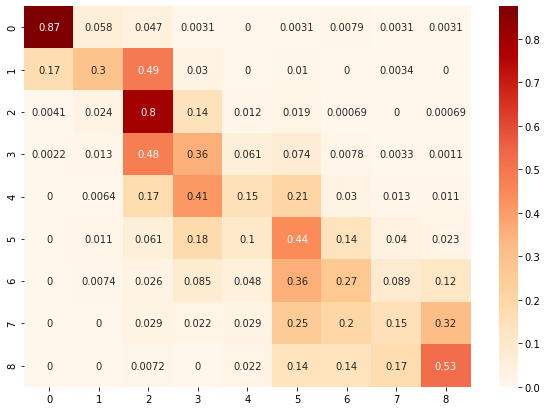

In [562]:
# load model
model = load_model('model_02.h5')

preds = model.predict(devGX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(devGY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(devGY, preds, normalize='true'), cmap='OrRd', annot = True)



## Predict my face

In [7]:
import cv2

img1 = cv2.imread('IMG_9788.jpg')
img2 = cv2.imread('IMG_9789.jpg')
img3 = cv2.imread('IMG_9790.jpg')

print(img1.shape, img2.shape, img3.shape)
print(np.max(img1))

(828, 828, 3) (828, 828, 3) (699, 699, 3)
255


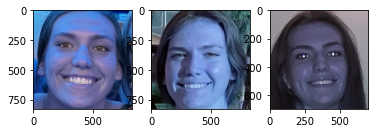

In [8]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(img1)
axarr[1].imshow(img2)
axarr[2].imshow(img3)

In [9]:
# Down sample images to 48 by 48
from skimage.transform import rescale, resize

smallImg1 = resize(img1, (img1.shape[0] // 17.25, img1.shape[1] // 17.25),
                       anti_aliasing=True)
smallImg2 = resize(img2, (img2.shape[0] // 17.25, img2.shape[1] // 17.25),
                       anti_aliasing=True)
smallImg3 = resize(img3, (48, 48),
                       anti_aliasing=True)

(48, 48, 3) (48, 48, 3) (48, 48, 3)


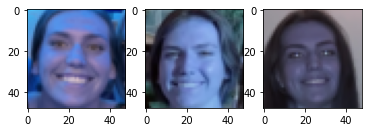

In [10]:
print(smallImg1.shape, smallImg2.shape, smallImg3.shape)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(smallImg1)
axarr[1].imshow(smallImg2)
axarr[2].imshow(smallImg3)


In [11]:
my_face = np.array([smallImg1, smallImg2, smallImg3])
my_face.shape

(3, 48, 48, 3)

In [13]:
model = tf.keras.models.load_model('modelW_01.h5')

preds = model.predict(my_face)
preds = preds.argmax(axis=1)

print(preds)

[26 26  1]


Yay! the model (with ~50% accuracy thinks I'm in my 20s (or 30s) and im 22 in all photos)

I'm just going to ignore that 30s prediction haha

(530, 530, 3) (507, 507, 3) (422, 422, 3)
231
(48, 48, 3) (48, 48, 3) (48, 48, 3)


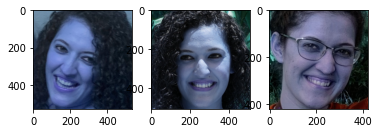

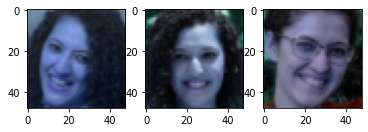

In [3]:
img1 = cv2.imread('IMG_9791.jpg')
img2 = cv2.imread('IMG_9792.jpg')
img3 = cv2.imread('IMG_9793.jpg')

print(img1.shape, img2.shape, img3.shape)
print(np.max(img1))

f, axarr = plt.subplots(1,3)
axarr[0].imshow(img1)
axarr[1].imshow(img2)
axarr[2].imshow(img3)

# Down sample images to 48 by 48
from skimage.transform import rescale, resize

smallImg1 = resize(img1, (48,48), anti_aliasing=True)
smallImg2 = resize(img2, (48,48), anti_aliasing=True)
smallImg3 = resize(img3, (48, 48), anti_aliasing=True)

print(smallImg1.shape, smallImg2.shape, smallImg3.shape)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(smallImg1)
axarr[1].imshow(smallImg2)
axarr[2].imshow(smallImg3)

In [6]:
my_face = np.array([smallImg1, smallImg2, smallImg3])
print(my_face.shape)

model = tf.keras.models.load_model('modelW_01.h5')

preds = model.predict(my_face)
preds = preds.argmax(axis=1)

print(preds)

(3, 48, 48, 3)
[ 3  1 21]


(813, 813, 3) (710, 710, 3) (620, 620, 3)
255
(48, 48, 3) (48, 48, 3) (48, 48, 3)


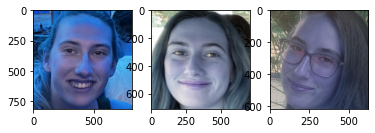

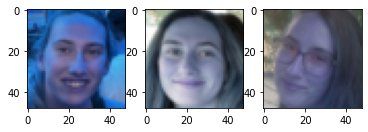

In [14]:
img1 = cv2.imread('IMG_9794.jpg')
img2 = cv2.imread('IMG_9795.jpg')
img3 = cv2.imread('IMG_9796.jpg')

print(img1.shape, img2.shape, img3.shape)
print(np.max(img1))

f, axarr = plt.subplots(1,3)
axarr[0].imshow(img1)
axarr[1].imshow(img2)
axarr[2].imshow(img3)

# Down sample images to 48 by 48
from skimage.transform import rescale, resize

smallImg1 = resize(img1, (48,48), anti_aliasing=True)
smallImg2 = resize(img2, (48,48), anti_aliasing=True)
smallImg3 = resize(img3, (48, 48), anti_aliasing=True)

print(smallImg1.shape, smallImg2.shape, smallImg3.shape)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(smallImg1)
axarr[1].imshow(smallImg2)
axarr[2].imshow(smallImg3)